In [6]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle

from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

import warnings
warnings.filterwarnings("ignore")

from preparation import *

sample_base = "mouse_based_trees"

In [7]:
storagedir = "/home/hieunguyen/CRC1382/storage"
inputdir = os.path.join(storagedir, "BCR_bulk_trees", sample_base)
outdir = "/home/hieunguyen/CRC1382/outdir"

path_to_01_output = os.path.join(outdir, "BCR_bulk_trees", "01_output")
os.system("mkdir -p {}".format(path_to_01_output))

files = [item for item in pathlib.Path(inputdir).glob("m*_full")]

list_of_samples = [item.name for item in files]

print("List of samples in this dataset: {}".format(list_of_samples))
print("***** ***** ***** ***** ***** ***** ***** ***** ***** *****")
print("Number of samples in this dataset: {}".format(len(list_of_samples)))

List of samples in this dataset: ['m53_full', 'm14_full', 'm42_full', 'm43_full', 'm37_full', 'm39_full', 'm30_full', 'm32_full', 'm29_full', 'm38_full', 'm13_full', 'm31_full', 'm28_full', 'm36_full', 'm11_full', 'm12_full']
***** ***** ***** ***** ***** ***** ***** ***** ***** *****
Number of samples in this dataset: 16


In [8]:
if os.path.exists(os.path.join(path_to_01_output, "all_samples_all_trees_dictionary.pkl")) == False:
    all_tree_featuredf = dict()
    
    for samplename in tqdm(list_of_samples):
        all_tree_featuredf[samplename] = pd.DataFrame(data = feature_names, columns = ["feature"])
        path_to_sample = os.path.join(inputdir, samplename)
        all_trees = [item for item in pathlib.Path(path_to_sample).glob("*") if os.path.isdir(item)]
        
        for treedir in all_trees:    
            treedir = str(treedir)
            nk_path = os.path.join(treedir, "gctree.out.inference.1.nk")
            if os.path.exists(nk_path) == True:
                ab_dict_path = os.path.join(treedir, "abund.csv")
                abund_df = pd.read_csv(ab_dict_path, index_col=0, names=['val'])
                ab_dict = abund_df.to_dict().get('val')
                tree_path = treedir
                tree = Tree(newick=nk_path, format=1)
                if ab_dict is not None:
                    for node in tree.traverse():
                        node.add_feature('abundance', ab_dict.get(node.name, 0))
                treeobj = GCtree(tree = tree, path = tree_path)
                tree_featuredf = pd.DataFrame(treeobj.summarize_tree_features().reset_index())
                tree_featuredf = tree_featuredf.tail(tree_featuredf.shape[0] - 2)
                tree_featuredf.columns = ["feature", "{}_{}".format(treeobj.sample_name, treeobj.tree_name)]
                all_tree_featuredf[samplename] = all_tree_featuredf[samplename].merge(tree_featuredf, right_on = "feature", left_on = "feature")
    with open(os.path.join(path_to_01_output, "all_samples_all_trees_dictionary.pkl"), 'wb') as fp:
        pickle.dump(all_tree_featuredf, fp)
else:
    with open(os.path.join(path_to_01_output, "all_samples_all_trees_dictionary.pkl"), 'rb') as fp:
        all_tree_featuredf = pickle.load(fp)

if os.path.exists(os.path.join(path_to_01_output, "all_samples_all_trees_featuredf.csv")) == False:
    featuredf = pd.DataFrame(data = all_tree_featuredf["m53_full"].feature.to_list(), columns = ["feature"])
    for sampleid in all_tree_featuredf.keys():
        featuredf = featuredf.merge(all_tree_featuredf[sampleid], right_on = "feature", left_on = "feature")
    featuredf.to_csv(os.path.join(path_to_01_output, "all_samples_all_trees_featuredf.csv"))
else:
    featuredf = pd.read_csv(os.path.join(path_to_01_output, "all_samples_all_trees_featuredf.csv"), index_col = [0])

100%|███████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it]


# Dimensional reduction methods on tree-Feature dataframes

## PCA plots

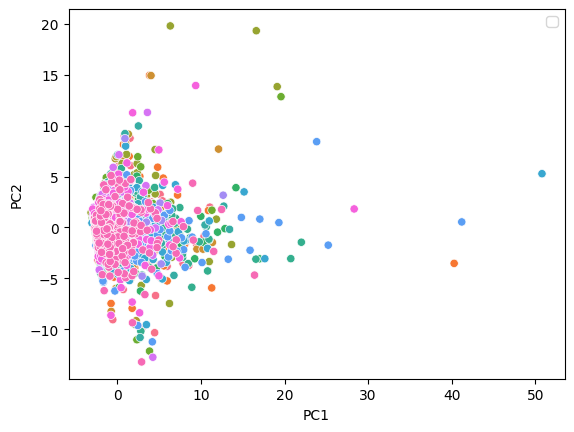

In [9]:
pca = PCA(n_components=2)
scaler = StandardScaler()

featuredf_noNA = featuredf.dropna(axis=1, how='any')
X = featuredf_noNA.set_index("feature").T.to_numpy()

X_scaled = scaler.fit_transform(X)

pca_matrix = pca.fit_transform(X_scaled)
pcadf = pd.DataFrame(data = list([item for item in featuredf_noNA.columns if item != "feature"]), columns = ["tree"])
pcadf[["PC1", "PC2"]] = pca_matrix
pcadf["origin_Sample"] = pcadf["tree"].apply(lambda x: x.split("_gctree")[0])

sns.scatterplot(data = pcadf, x = "PC1", y = "PC2", hue = "origin_Sample")
plt.legend([])
plt.show()

## UMAP plots

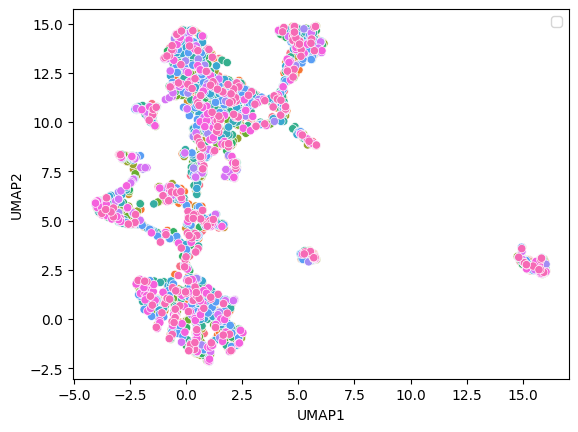

In [10]:
reducer = umap.UMAP()
umap_matrix = reducer.fit_transform(X_scaled)
umapdf = pd.DataFrame(data = list([item for item in featuredf_noNA.columns if item != "feature"]), columns = ["tree"])
umapdf[["UMAP1", "UMAP2"]] = umap_matrix
umapdf["origin_Sample"] = umapdf["tree"].apply(lambda x: x.split("_gctree")[0])

sns.scatterplot(data = umapdf, x = "UMAP1", y = "UMAP2", hue = "origin_Sample")
plt.legend([])
plt.show()

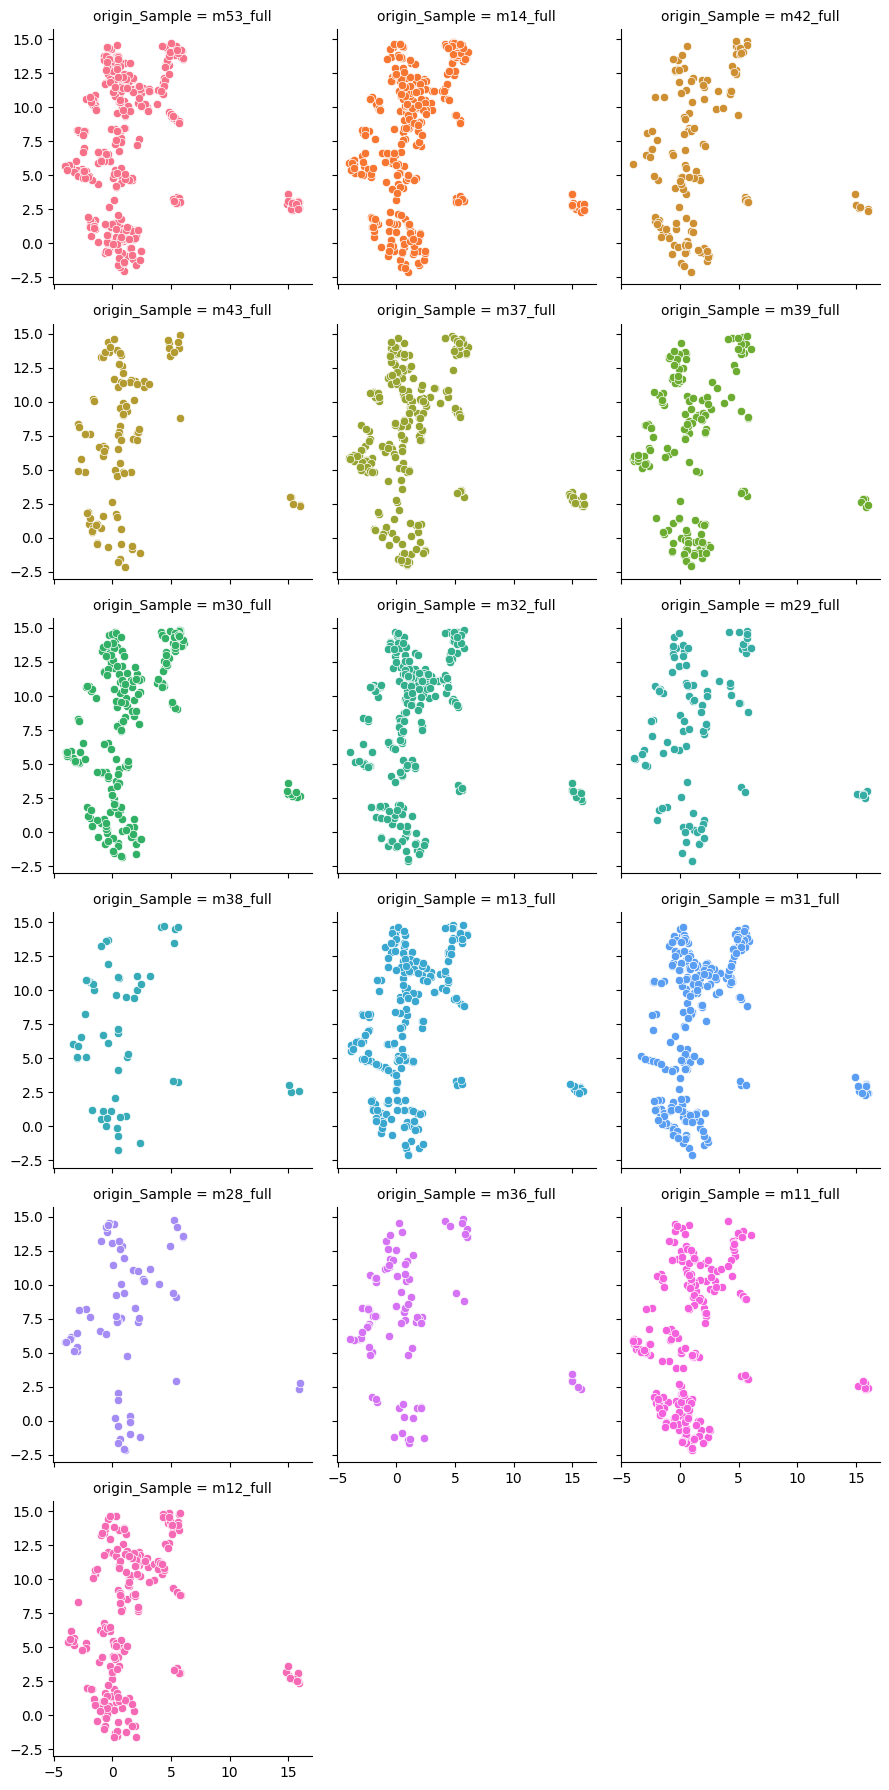

In [11]:
g = sns.FacetGrid(umapdf, col = "origin_Sample", col_wrap = 3, hue = "origin_Sample")
g.map_dataframe(sns.scatterplot, x="UMAP1", y = "UMAP2")
plt.show()

EOF

In [12]:
featuredf

,feature,m53_full_gctree_IGHV1-11_IGHJ2_30_9.1,m53_full_gctree_IGHV1-76_IGHJ1_54_3515.3,m53_full_gctree_IGHV1-62-2_IGHJ2_33_2405.1,m53_full_gctree_IGHV1-26_IGHJ1_30_577.1,m53_full_gctree_IGHV1-19_IGHJ3_36_378.1,m53_full_gctree_IGHV1-9_IGHJ1_51_4381.1,m53_full_gctree_IGHV1-69_IGHJ2_30_2864.1,m53_full_gctree_IGHV1-9_IGHJ1_39_4367.2,m53_full_gctree_IGHV1-64_IGHJ2_36_2594.1,...,m12_full_gctree_IGHV1-64_IGHJ4_48_2736.4,m12_full_gctree_IGHV5-15_IGHJ4_51_6097.1,m12_full_gctree_IGHV1-72_IGHJ3_27_3161.3,m12_full_gctree_IGHV1-74_IGHJ2_45_3296.1,m12_full_gctree_IGHV1-59_IGHJ4_48_2333.1,m12_full_gctree_IGHV1-75_IGHJ3_33_3419.1,m12_full_gctree_IGHV1-53_IGHJ4_45_1862.1,m12_full_gctree_IGHV1-55_IGHJ1_45_1960.1,m12_full_gctree_IGHV1-26_IGHJ4_39_882.1,m12_full_gctree_IGHV1-22_IGHJ1_54_453.1
0,n_nodes,5.0,3.0,6.0,16.0,4.0,12.0,8.0,4.0,14.0,...,3.0,4.0,13.0,4.0,5.0,4.0,4.0,4.0,4.0,11.0
1,n_leaves,3.0,1.0,3.0,10.0,2.0,6.0,4.0,2.0,7.0,...,1.0,2.0,6.0,2.0,3.0,2.0,2.0,2.0,2.0,6.0
2,p_leaves,0.6,0.333333,0.5,0.625,0.5,0.5,0.5,0.5,0.5,...,0.333333,0.5,0.461538,0.5,0.6,0.5,0.5,0.5,0.5,0.545455
3,n_internals,1.0,1.0,2.0,5.0,1.0,5.0,3.0,1.0,6.0,...,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
4,p_internals,0.2,0.333333,0.333333,0.3125,0.25,0.416667,0.375,0.25,0.428571,...,0.333333,0.25,0.461538,0.25,0.2,0.25,0.25,0.25,0.25,0.363636
5,n_ptn,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,p_ptn,0.0,0.333333,0.0,0.0625,0.0,0.166667,0.0,0.0,0.071429,...,0.333333,0.0,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,n_obs,4.0,2.0,3.0,12.0,2.0,9.0,4.0,2.0,10.0,...,2.0,2.0,9.0,3.0,3.0,3.0,2.0,2.0,2.0,7.0
8,p_obs,0.8,0.666667,0.5,0.75,0.5,0.75,0.5,0.5,0.714286,...,0.666667,0.5,0.692308,0.75,0.6,0.75,0.5,0.5,0.5,0.636364
9,n_inf,1.0,1.0,3.0,4.0,2.0,3.0,4.0,2.0,4.0,...,1.0,2.0,4.0,1.0,2.0,1.0,2.0,2.0,2.0,4.0
